In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

## Summary

* no missing data
* different satelites have different number of observations (max is 6320, min is 94)
* there are strong systematic nonlinear(!) discrepancies between simaluted and real values for coordinates and for speeds. The shape of deviation looks like lissajou figures (but may have nothing to do with them) 
* there is obvious 'dephasing' between simulated and real values. That is, in the beginning of the simulations, the matching between is almost perfect, but at the end of simulation there is clear phase difference.

In [17]:
data = pd.read_csv('train.csv', index_col= 'id')
data.head(3)

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649912 entries, 0 to 1234093
Data columns (total 14 columns):
epoch     649912 non-null object
sat_id    649912 non-null int64
x         649912 non-null float64
y         649912 non-null float64
z         649912 non-null float64
Vx        649912 non-null float64
Vy        649912 non-null float64
Vz        649912 non-null float64
x_sim     649912 non-null float64
y_sim     649912 non-null float64
z_sim     649912 non-null float64
Vx_sim    649912 non-null float64
Vy_sim    649912 non-null float64
Vz_sim    649912 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 74.4+ MB


In [6]:
# checking missing values
data.isna().sum(axis = 'rows')

epoch     0
sat_id    0
x         0
y         0
z         0
Vx        0
Vy        0
Vz        0
x_sim     0
y_sim     0
z_sim     0
Vx_sim    0
Vy_sim    0
Vz_sim    0
dtype: int64

In [18]:
sat_obs = data.sat_id.value_counts()
print('maxinum number of observations: {}'.format(sta_obs.max()))
print('minimum number of observations: {}'.format(sta_obs.min()))

maxinum number of observations: 6320
minimum number of observations: 94


Text(0, 0.5, 'x')

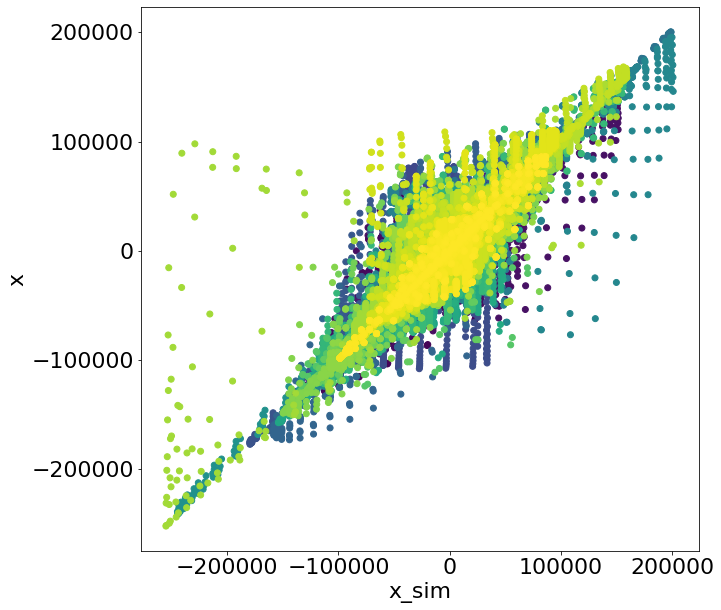

In [61]:
# see how different the simulated coordinates from predicted
plt.figure(figsize=(10,10))
plt.scatter(data.x_sim,data.x,c=data.sat_id)
plt.xlabel("x_sim")
plt.ylabel("x")

Text(0, 0.5, 'Vx')

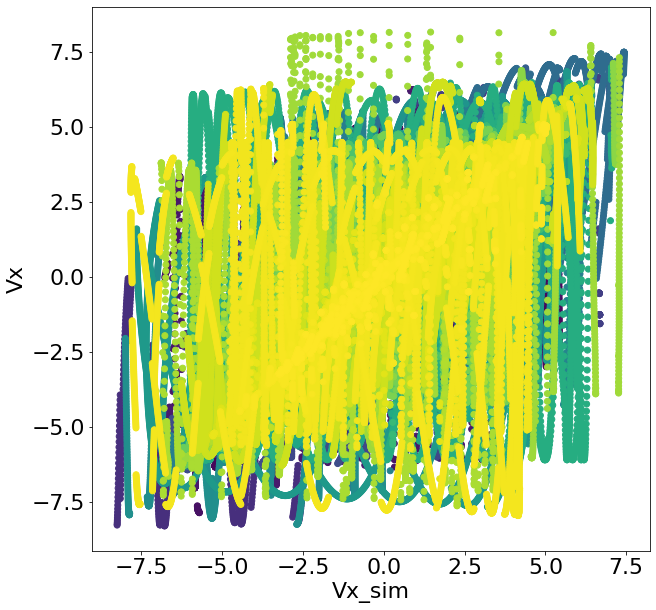

In [62]:
# see how different the simulated coordinates from predicted

plt.figure(figsize=(10,10))
plt.scatter(data.Vx_sim,data.Vx,c=data.sat_id)
plt.xlabel("Vx_sim")
plt.ylabel("Vx")

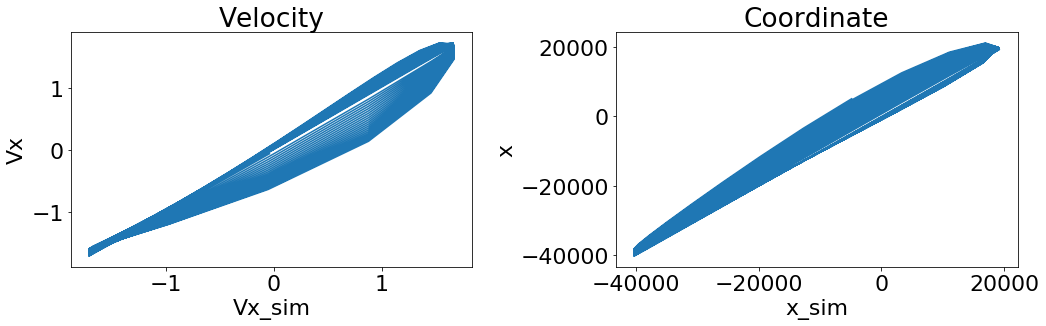

In [96]:
# let us look at a single satelite
data_sat = data[data.sat_id == 300]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), linewidth = 0.1)
ax1.plot(data_sat.Vx_sim,data_sat.Vx)
ax1.set_title("Velocity")
ax1.set_xlabel("Vx_sim")
ax1.set_ylabel("Vx")
ax2.plot(data_sat.x_sim,data_sat.x)
ax2.set_title("Coordinate")
ax2.set_xlabel("x_sim")
ax2.set_ylabel("x")
plt.tight_layout()


# Looking at the satelite with the largest data points

In [94]:
# let's look at the data for the satelite with the larget amount of data
m_id = sta_obs.sort_values().index[-1]

372

Text(0, 0.5, 'Vx')

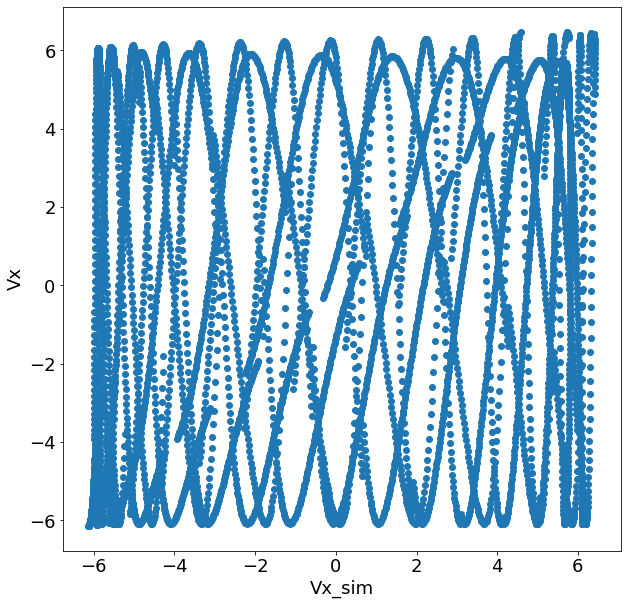

In [145]:
m_data = data[data.sat_id == m_id]

plt.figure(figsize=(10,10))
plt.scatter(m_data.Vx_sim,m_data.Vx)
plt.xlabel("Vx_sim")
plt.ylabel("Vx")

Text(0, 0.5, 'x')

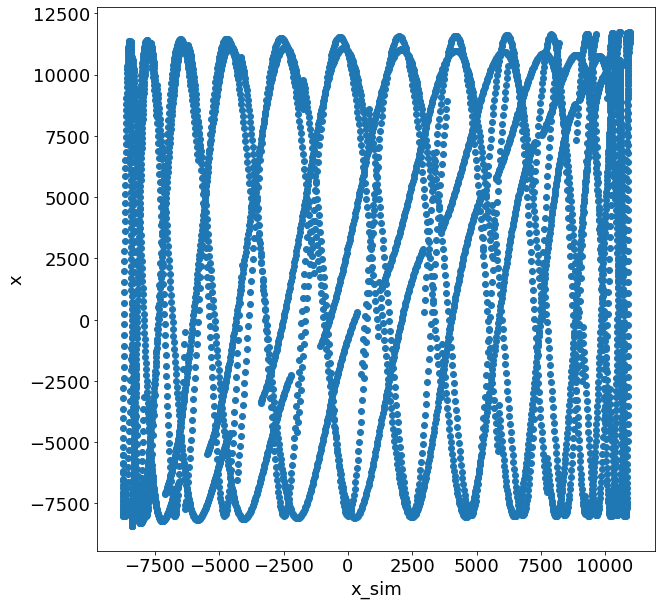

In [146]:
plt.figure(figsize=(10,10))
plt.scatter(m_data.x_sim,m_data.x)
plt.xlabel("x_sim")
plt.ylabel("x")

In [147]:
# low let's consider it as a time series
m_data.epoch = pd.to_datetime(m_data.epoch[:,])
m_data.set_index('epoch', inplace = True)
m_data.head()

,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
epoch,,,,,,,,,,,,,
2014-01-01 00:00:00.000,372,-7864.678484,-3129.694640,2907.635431,-2.245256,6.608261,1.039890,-7860.046460,-3132.109662,2904.845788,-2.248154,6.610960,1.041413
2014-01-01 00:07:03.869,372,-8412.117022,-220.195147,3197.249996,-0.322000,7.005179,0.317406,-8408.384650,-221.380394,3195.033561,-0.323371,7.008780,0.318784
2014-01-01 00:14:07.738,372,-8142.359815,2712.345768,3175.824997,1.569116,6.723347,-0.411696,-8138.889636,2712.535682,3174.147312,1.569253,6.726703,-0.410586
2014-01-01 00:21:11.606,372,-7118.319697,5395.817612,2859.815398,3.207649,5.855679,-1.061148,-7114.320644,5397.827305,2858.516662,3.208626,5.859393,-1.059693
2014-01-01 00:28:15.475,372,-5478.816040,7618.661585,2296.340781,4.454570,4.574468,-1.571567,-5474.803399,7620.801613,2295.605579,4.455283,4.576093,-1.570595


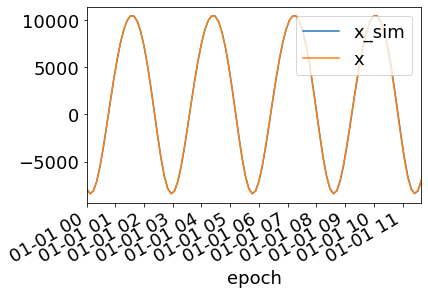

In [148]:
m_data[:100].x_sim.plot(label = 'x_sim')
m_data[:100].x.plot(label = 'x')
plt.legend(loc = 1)

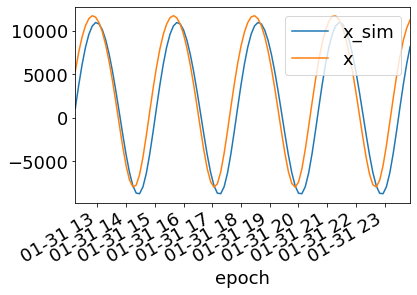

In [149]:
m_data[-100:].x_sim.plot(label = 'x_sim')
m_data[-100:].x.plot(label = 'x')
plt.legend(loc = 1)

Looks like the phase and the offset between the simulation and the real value are changing with time.

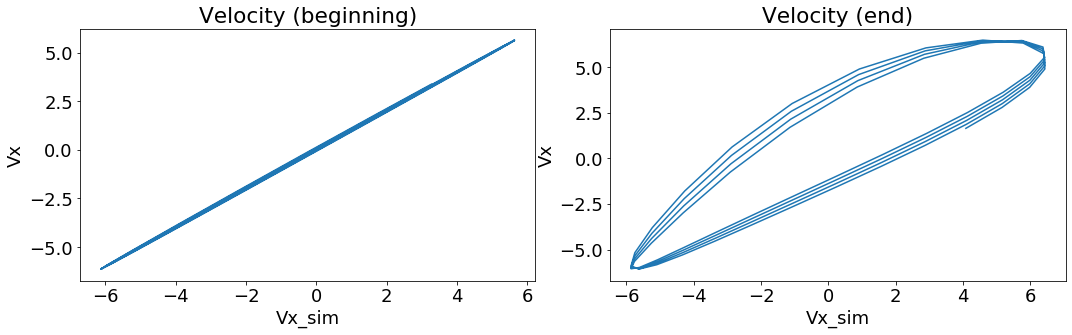

In [151]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), linewidth = 0.1)
ax1.plot(m_data[:100].Vx_sim,m_data[:100].Vx)
ax1.set_title("Velocity (beginning)")
ax1.set_xlabel("Vx_sim")
ax1.set_ylabel("Vx")

ax2.plot(m_data[-100:].Vx_sim,m_data[-100:].Vx)
ax2.set_title("Velocity (end)")
ax2.set_xlabel("Vx_sim")
ax2.set_ylabel("Vx")
plt.tight_layout()

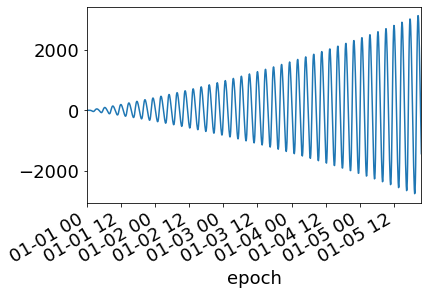

In [185]:
difference = m_data.x-m_data.x_sim
difference[:1000].plot()

# Let's look at Fourier transform

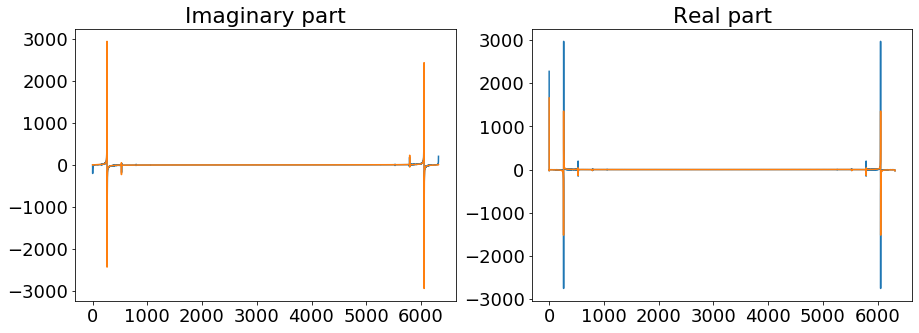

In [167]:
s = np.fft.ifft(m_data.x)
s_sim = np.fft.ifft(m_data.x_sim)
t = np.arange(len(m_data.x))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), linewidth = 0.1)
ax1.set_title("Imaginary part")
ax1.plot(t, s.imag)
ax1.plot(t, s_sim.imag)

ax2.set_title("Real part")
ax2.plot(t, s.real)
ax2.plot(t, s_sim.real)

(-250, 250)

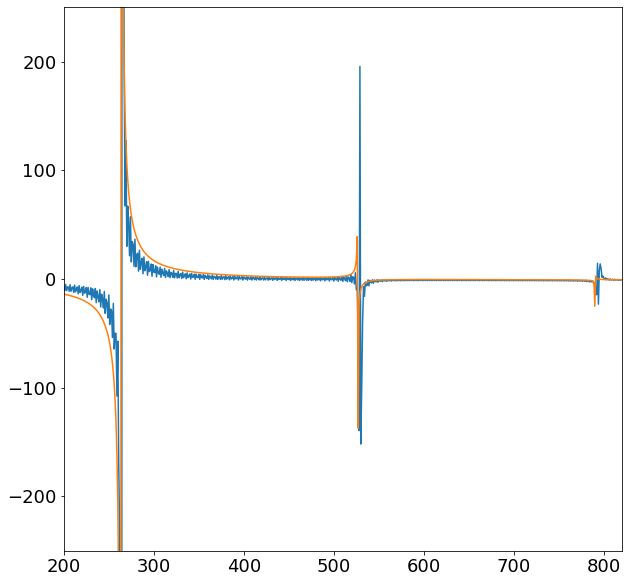

In [182]:
plt.figure(figsize=(10,10))
plt.plot(t, s.real)
plt.plot(t, s_sim.real)
plt.xlim([200,820])
plt.ylim([-250,250])

(-250, 250)

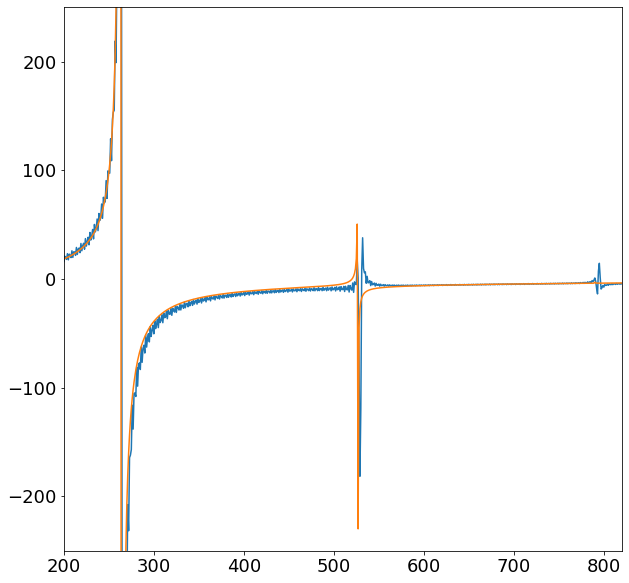

In [186]:
plt.figure(figsize=(10,10))
plt.plot(t, s.imag)
plt.plot(t, s_sim.imag)
plt.xlim([200,820])
plt.ylim([-250,250])